In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
seed = 314
num_trial = 300

In [3]:
def dof(y,y_hat):
    n = y.shape[0]
    K = y.shape[1]
    y_mean = np.mean(y, axis =1, keepdims=True)
    y_hat_mean = np.mean(y_hat, axis =1, keepdims=True)
    return np.sum((y-y_mean) * (y_hat-y_hat_mean))/(K)

# Simple example

In [6]:
np.random.seed(seed)
n = 2
mu_max = 10
var_noise = 1
df = np.zeros([(2*mu_max+1),(2*mu_max+1)])
for i in np.arange(df.shape[0]):
    for j in np.arange(df.shape[0]):
        # mu
        mu = np.array([(i-mu_max),(j-mu_max)])
        #estimate df
        y_val = np.zeros([n,num_trial])
        y_hat = np.zeros([n,num_trial])
        for k in np.arange(num_trial):

            y = np.random.multivariate_normal(mu,var_noise*np.eye(2), size =1).reshape([-1,1])
            #fit in univariate model
            fit0 = y * np.array([[1],[0]])
            fit1 = y * np.array([[0],[1]])
            fit = [fit0,fit1]
            #compute sigma
            rss0 = (np.sum((y-fit0)**2)/(n-1))
            rss1 = (np.sum((y-fit1)**2)/(n-1))
            #best subset
            best = 1*(rss0>rss1)
            y_val[:,k] = y.reshape(-1)
            y_hat[:,k] = fit[best].reshape(-1)
        df[i,j] = dof(y_val,y_hat)

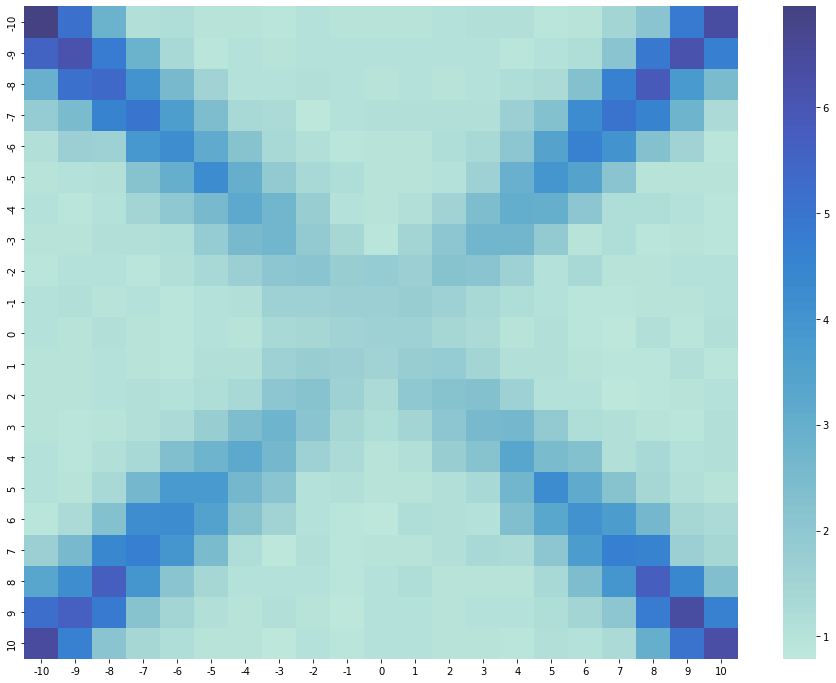

In [13]:
df_pd = pd.DataFrame(df)
sns.heatmap(df_pd,center = 10,xticklabels=(np.arange(2*mu_max+1)-mu_max),yticklabels=(np.arange(2*mu_max+1)-mu_max))
plt.rcParams["figure.figsize"] = (16,20)
plt.show()

# Best subset selection

In [4]:
np.random.seed(seed)
n = 100
p = 15
snr =7
from sklearn.feature_selection import SelectKBest,f_regression
beta = np.random.normal(0,1,size = [p,1])
X = np.random.normal(0,1,size = [n,p])
mu = snr*(X @ beta)
df = np.zeros(p)

for i in np.arange(p):
    #estimate df
    y_val = np.zeros([n,num_trial])
    y_hat = np.zeros([n,num_trial])
    for k in np.arange(num_trial):
        #generate y
        y = mu+np.random.normal(0,1,size = [n,1])
        #find the best subset
        X_new = SelectKBest(f_regression, k=(i+1)).fit_transform(X, y.reshape(-1))
        #fit
        y_val[:,k] = y.reshape(-1)
        y_hat[:,k] = (X_new@np.linalg.inv(X_new.T @ X_new)@X_new.T@y).reshape(-1)
    df[i] = dof(y_val,y_hat)

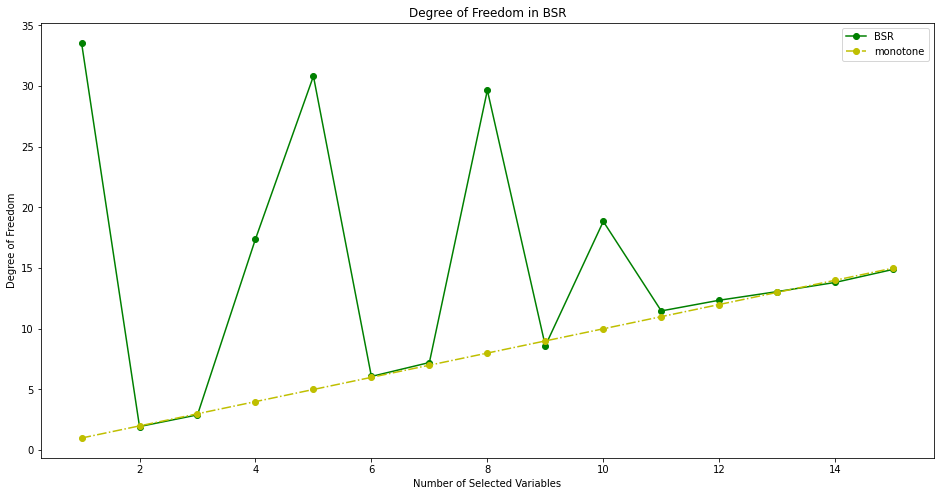

In [11]:
plt.plot((1+np.arange(p)),df,'-go')
plt.plot((1+np.arange(p)),(1+np.arange(p)),'-.yo')
plt.title("Degree of Freedom in BSR")
plt.xlabel("Number of Selected Variables")
plt.ylabel("Degree of Freedom")
plt.legend(["BSR","monotone"])
plt.rcParams["figure.figsize"] = (16,8)
plt.show()

# Lasso(sklearn)

In [43]:
np.random.seed(seed)
from sklearn import linear_model

n=2
p=2
X = np.array([[0,1],[2,-5]])
beta = np.array([[-6],[-1]])
num_trial =100
num_batch = 10
lmd = np.exp(np.arange(-5,3,0.01))#4/l*np.arange(l)
l = lmd.shape[0]
beta_lasso = np.zeros([l,p])

mu = (X @ beta)
df = np.zeros([l,num_batch])
for i in np.arange(l):
    beta_lasso[i,:] = ((linear_model.Lasso(alpha=lmd[i],fit_intercept=False)).fit(X,mu).coef_).reshape([1,-1])
    for v in np.arange(num_batch):
        #estimate df
        y_val = np.zeros([n,num_trial])
        y_hat = np.zeros([n,num_trial])
        for k in np.arange(num_trial):
            #generate y
            y = mu+np.random.normal(0,0.03,size = [n,1])
            #fit
            y_val[:,k] = y.reshape(-1)
            y_hat[:,k] = ((X@((linear_model.Lasso(alpha=lmd[i],fit_intercept=False)).fit(X,y).coef_.reshape([-1,1]))).reshape([-1,1])).reshape(-1)
        df[i,v] = dof(y_val,y_hat)/(0.03**2)

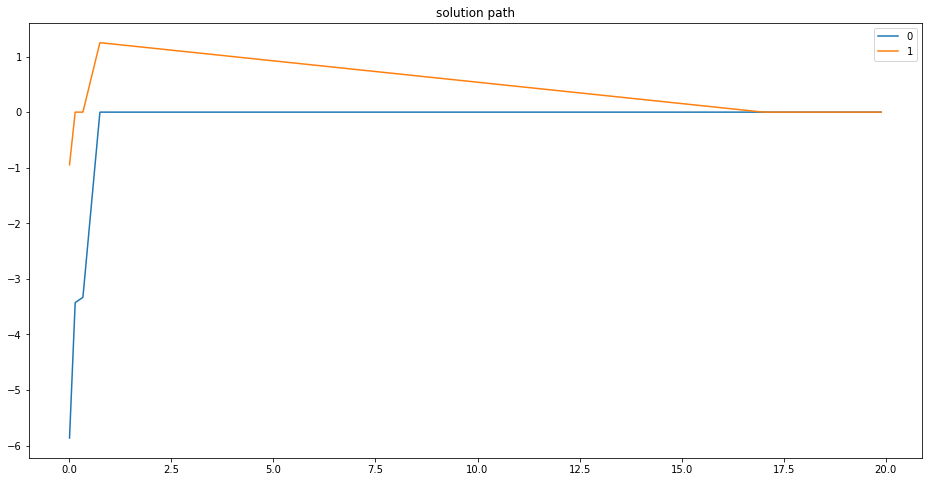

In [44]:
df_beta = pd.DataFrame(data=beta_lasso, index = lmd, columns=np.arange(p))
plt_beta = df_beta.plot(title = "solution path")
plt.rcParams["figure.figsize"] = (16,8)
plt.show()

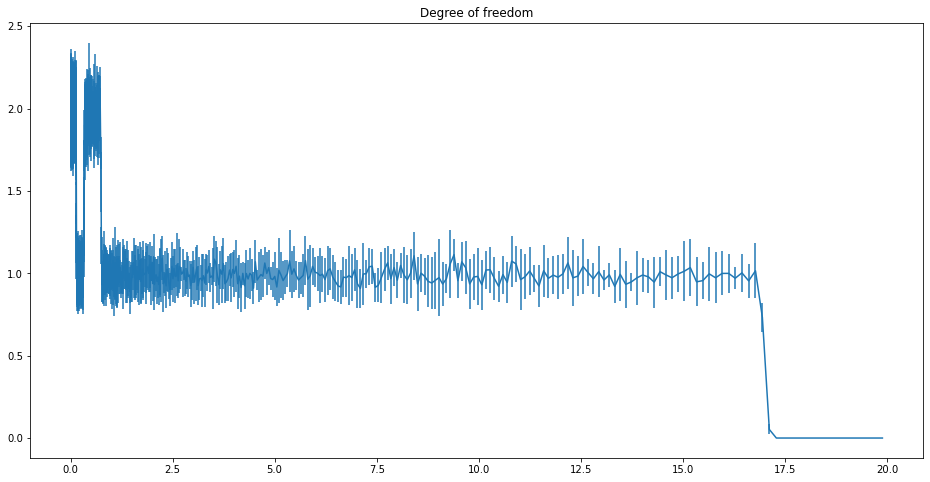

In [45]:
plt.errorbar(x=lmd,y=np.mean(df,axis =1),yerr=np.std(df,axis =1))
plt.title("Degree of freedom")
plt.rcParams["figure.figsize"] = (16,8)
plt.show()

# Lasso(the soft-shrinakge closed form)

In [12]:
def lasso(X,y,lmd):
    lmd = 2*lmd
    p = X.shape[1]
    n = X.shape[0]
    beta_LS = np.linalg.inv(X.T @X)@X.T @y
    beta = np.abs(beta_LS)-lmd
    beta[beta<0] = 0
    beta = beta*np.sign(beta_LS)
    return (beta)

In [16]:
np.random.seed(seed)
from sklearn import linear_model

n=2
p=2
X = np.array([[0,1],[2,-5]])
beta = np.array([[-6],[-1]])
num_trial =300
num_batch = 20
lmd = np.exp(np.arange(-5,1.5,0.01))#4/l*np.arange(l)
l = lmd.shape[0]
beta_lasso = np.zeros([l,p])

mu = (X @ beta)
df = np.zeros([l,num_batch])
for i in np.arange(l):
    beta_lasso[i,:] = lasso(X,mu,n*lmd[i]).reshape([1,-1])
    for v in np.arange(num_batch):
        #estimate df
        y_val = np.zeros([n,num_trial])
        y_hat = np.zeros([n,num_trial])
        for k in np.arange(num_trial):
            #generate y
            y = mu+np.random.normal(0,0.03,size = [n,1])
            #fit
            y_val[:,k] = y.reshape(-1)
            y_hat[:,k] = (X@(lasso(X,y,n*lmd[i]).reshape([-1,1]))).reshape(-1)
        df[i,v] = dof(y_val,y_hat)/(0.03**2)

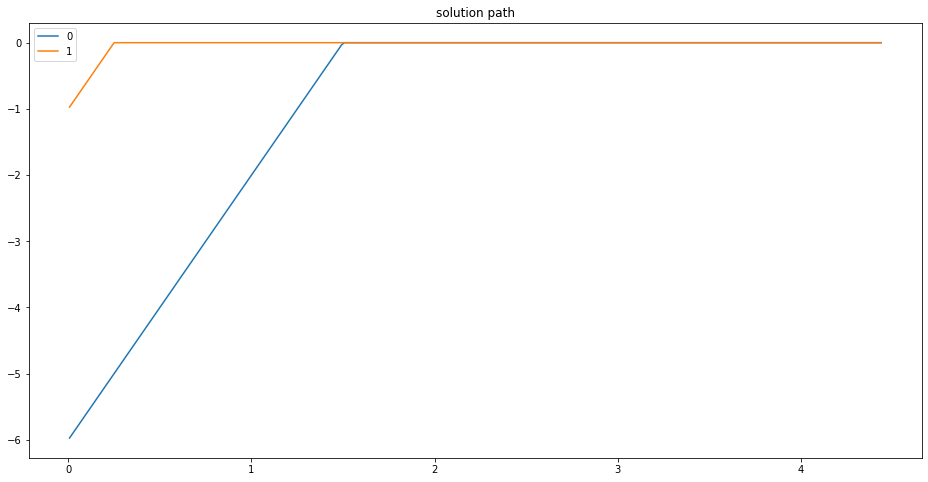

In [17]:
df_beta = pd.DataFrame(data=beta_lasso, index = lmd, columns=np.arange(p))
plt_beta = df_beta.plot(title = "solution path")
plt.rcParams["figure.figsize"] = (16,8)
plt.show()

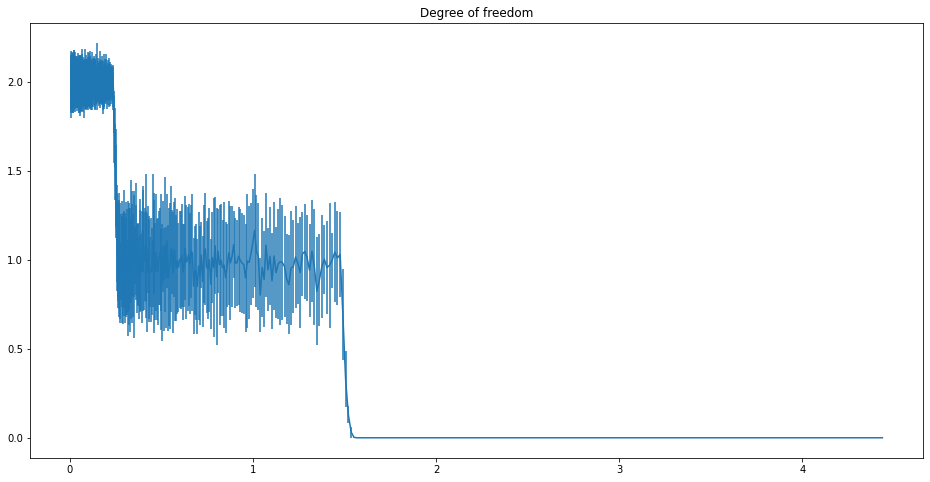

In [18]:
plt.errorbar(x=lmd,y=np.mean(df,axis =1),yerr=np.std(df,axis =1))
plt.title("Degree of freedom")
plt.rcParams["figure.figsize"] = (16,8)
plt.show()

# Ridge

In [96]:
def ridge(X,y,lmd):
    p = X.shape[1]
    beta = np.linalg.inv(X.T @X+lmd*np.eye(p))@X.T @y
    return (beta)

In [113]:
np.random.seed(seed)
n = 20
p = 5
# n=2
# p=2
# X = np.array([[0,1],[2,-5]])
# beta = np.array([[-6],[-1]])
num_trial =500
snr =10
l = 100
lmd = np.exp(np.log(3e4)/l*np.arange(l))#4/l*np.arange(l)#
beta_ridge = np.zeros([l,p])

beta = np.zeros([p,1])
beta[1] = 1
beta[2] =0.2
beta[3] =-0.5
beta[4] = -1
X = snr*np.random.normal(0,1,size = [n,p])
mu = (X @ beta)
df = np.zeros(l)
for i in np.arange(l):
    beta_ridge[i,:] = ridge(X,mu,lmd[i]).reshape([1,-1])
    #estimate df
    y_val = np.zeros([n,num_trial])
    y_hat = np.zeros([n,num_trial])
    for k in np.arange(num_trial):
        #generate y
        y = mu+np.random.normal(0,1,size = [n,1])
        #fit
        y_val[:,k] = y.reshape(-1)
        y_hat[:,k] = (X@ridge(X,y,lmd[i]).reshape([-1,1])).reshape(-1)
    df[i] = dof(y_val,y_hat)

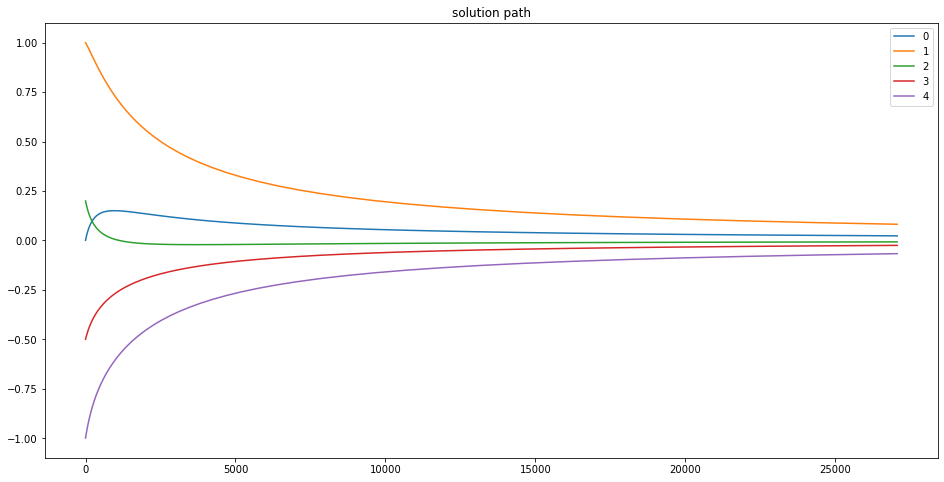

In [114]:
beta_df = pd.DataFrame(data=beta_ridge, index = lmd, columns=np.arange(p))
plt_beta = beta_df.plot(title = "solution path")
plt.rcParams["figure.figsize"] = (16,8)
plt.show()

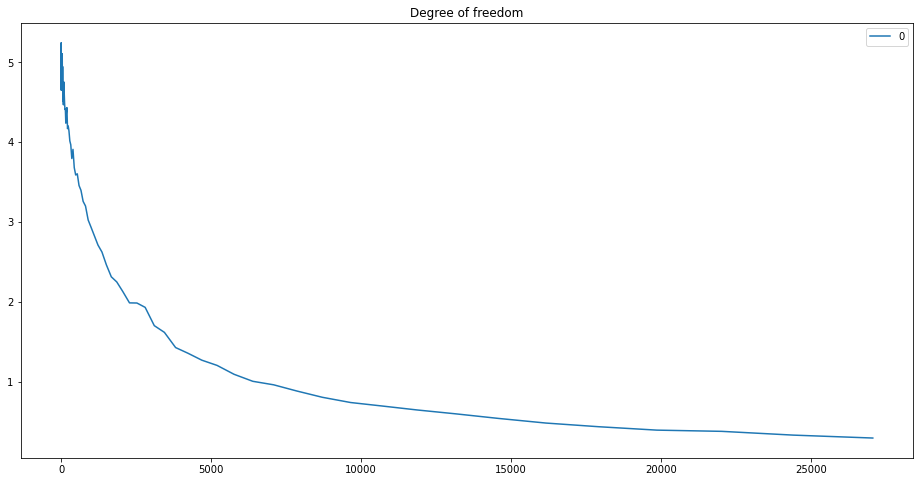

In [115]:
df_pd = pd.DataFrame(data=df, index = lmd)
plt_df = df_pd.plot(title = "Degree of freedom")
plt.rcParams["figure.figsize"] = (16,8)
plt.show()

# Bivariate revisit

In [65]:
np.random.seed(seed)
n = 2
mu_len = 20
var_noise = 1
mu_val = np.exp(np.log(1e3)/mu_len*np.arange(mu_len))
df = np.zeros([(mu_len),(mu_len)])
for i in np.arange(df.shape[0]):
    for j in np.arange(df.shape[0]):
        # mu
        mu = np.array([mu_val[i],mu_val[j]])
        #estimate df
        y_val = np.zeros([n,num_trial])
        y_hat = np.zeros([n,num_trial])
        for k in np.arange(num_trial):

            y = np.random.multivariate_normal(mu,var_noise*np.eye(2), size =1).reshape([-1,1])
            #fit in univariate model
            fit0 = y * np.array([[1],[0]])
            fit1 = y * np.array([[0],[1]])
            fit = [fit0,fit1]
            #compute sigma
            rss0 = (np.sum((y-fit0)**2)/(n-1))
            rss1 = (np.sum((y-fit1)**2)/(n-1))
            #best subset
            best = 1*(rss0>rss1)
            y_val[:,k] = y.reshape(-1)
            y_hat[:,k] = fit[best].reshape(-1)
        df[i,j] = dof(y_val,y_hat)

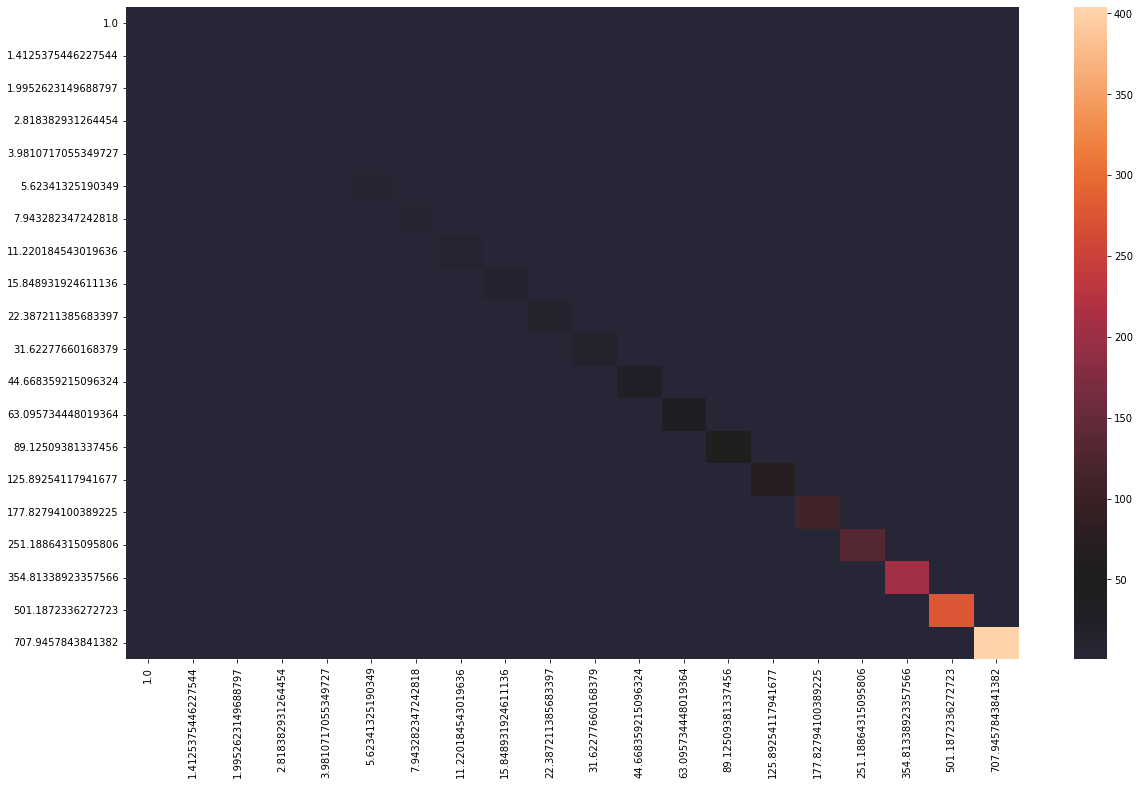

In [75]:
from matplotlib.colors import LogNorm
df_pd = pd.DataFrame(df)
sns.heatmap(df_pd,center =50,xticklabels=mu_val,yticklabels=mu_val)#,norm=LogNorm())
plt.rcParams["figure.figsize"] = (8,8)
plt.show()